In [8]:
import pandas as pd
import numpy as np
import os

def pred_dataset(file_names):
    source_path = 'C:/Kai_Zhang/MachineLearning/Unified gas Adsorption/CO2_adsorption/new_data'
    dataset = pd.DataFrame()
    
    for file_name in file_names:
        temp_data = pd.read_excel(os.path.join(source_path,file_name+'-01-10-2022.xlsx'),skiprows= 1 )
        temp_data = temp_data.dropna(axis=0,how = 'any',subset = ["BET",'Vt','Vmic','Vmeso'])
        temp_data = temp_data[temp_data['Pressure']>0.01]
        dataset = pd.concat([dataset,temp_data],axis=0)  
    return dataset

In [1]:
import pandas as pd
import numpy as np

def pred_dataset(file_names):
    source_path = 'C:/Kai_Zhang/MachineLearning/Unified gas Adsorption/CO2_adsorption/new_data'
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    for file_name in file_names:
        temp_data = pd.read_excel(os.path.join(source_path,file_name+'-01-10-2022.xlsx'),skiprows= 1 )
        
        temp_data = temp_data.dropna(axis=0,how = 'any',subset = ["BET",'Vt',])
        temp_data = temp_data[temp_data['Pressure']>0.01]
        #temp_data = temp_data[temp_data['Vmic']<2]
        index = list(set(temp_data['Index'].values))
        print(len(index))
        test_index= np.random.choice(index,int(0.2*len(index)),replace=False)
        train_x = temp_data.loc[~temp_data['Index'].isin( test_index)]
        test_x = temp_data.loc[temp_data['Index'].isin(test_index)]
        
        train_df = pd.concat([train_df,train_x],axis=0)
        test_df = pd.concat([test_df,test_x],axis =0)
    return train_df,test_df

In [9]:
train_df = pred_dataset(['CO2','Methane','Ethane&Ethylene','CFCs'])

In [10]:
train_df.shape

(26956, 26)

In [2]:
train_df,test_df = pred_dataset(['CO2','Methane','Ethane&Ethylene','CFCs'])

2160
832
394
120


In [11]:
from sklearn.model_selection import GridSearchCV,cross_validate,GroupKFold
from sklearn.ensemble import ExtraTreesRegressor
from  sklearn.metrics import mean_squared_error,r2_score
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import LeavePGroupsOut


def model_CV(train_x,train_y,groups,model,para_grid):
    
    
    out_cv = GroupKFold(n_splits = 5)
    result = GridSearchCV(model,para_grid,cv= out_cv.get_n_splits(groups =groups),
    scoring='neg_mean_squared_error', return_train_score=True,n_jobs=-1)
    result.fit(train_x,train_y)
    
    model_refit =model.set_params(**result.best_params_)
    train_cv = cross_validate(model_refit,train_x,train_y,groups = groups,cv =out_cv,scoring = ('r2', 'neg_mean_squared_error'))
    train_mse_cv = -train_cv['test_neg_mean_squared_error'].mean()
    train_r2_cv = train_cv['test_r2'].mean()
    
    return [train_r2_cv,train_mse_cv],result.best_params_

def LOO_CV(model,train_x,train_y,groups,label = '0'):
    
    out_cv = LeavePGroupsOut(n_groups=1)
    train_y_real = np.array([])
    train_y_pred = np.array([])
    train_y_label = np.array([])

    for train_index, test_index in out_cv.split(train_x, train_y, groups):

    
        X_train, X_test = train_x[train_index], train_x[test_index]
        y_train, y_test = train_y[train_index], train_y[test_index]
        if len(label)>1:
            label_test = label[test_index]
            train_y_label = np.append(train_y_label,label_test)

        model.fit(X_train,y_train.squeeze())
        temp_pred = model.predict(X_test)
        train_y_real = np.append(train_y_real,y_test)
        train_y_pred = np.append(train_y_pred,temp_pred)
        
    
    if len(label)>1:
        return train_y_real,train_y_pred,train_y_label
    else:
        return train_y_real,train_y_pred


# comparing different models
def model_comparison(model_list,para_grids,feature_list):
    gas_list = ['total','CO2','CFCs','Methane','E&E']
    input_feature = feature_list
    output = ['Adsorp(mmol/g)']
    result_total = []

    for gas in gas_list:
        
        if gas =='total':

            train_df_com = train_df
            train_x = train_df_com[input_feature].values
            train_y = train_df_com[output].values
            groups = train_df_com['Index'].values
            labels = train_df_com["Label"].values
            
            for model_name, model in model_list:

                result, best_param = model_CV(train_x,train_y.squeeze(),groups,model,para_grids[model_name])
                model_refit = model.set_params(**best_param)
                y_real,y_pred,label = LOO_CV(model_refit,train_x,train_y.squeeze(),groups,labels) 
                test_r2_total = r2_score(y_real,y_pred)
                test_mse_total = mean_squared_error(y_real,y_pred)
                new_df =pd.DataFrame()
                new_df['Y_real'] = y_real
                new_df['Y_pred'] = y_pred
                new_df['Label']  = label
                #new_df = pd.DataFrame(np.array([,y_pred,label]),columns = ['Y_real','Y_pred','Label'])
                for gas in gas_list[1:]:
                    test_df_com = new_df[new_df['Label']==gas]
                    test_xs = test_df_com['Y_real'].values
                    test_ys = test_df_com['Y_pred'].values
                    test_r2,test_mse = r2_score(test_xs,test_ys),mean_squared_error(test_xs,test_ys)
                    result_total.append([gas,model_name+'_total',result[0],result[1],test_r2_total,test_mse_total,test_r2,test_mse,best_param])

                    print('Dataset {}, Algorithm {}, Test_r2 {}, Test_error {}'.format(gas,model_name+'_total',test_r2,test_mse))

            
        else:
            
            train_df_com = train_df[train_df['Label']==gas]
            train_x = train_df_com[input_feature].values
            train_y = train_df_com[output].values
            groups = train_df_com['Index'].values
    
            for model_name, model in model_list:
                result, best_param = model_CV(train_x,train_y.squeeze(),groups,model,para_grids[model_name])
                model_refit = model.set_params(**best_param)
                test_real,test_pred = LOO_CV(model_refit,train_x,train_y.squeeze(),groups) 
                test_r2,test_mse = r2_score(test_real,test_pred),mean_squared_error(test_real,test_pred)
                result_total.append([gas,model_name+'_separate',result[0],result[1],-1,-1, test_r2,test_mse,best_param])
                
    return result_total

In [5]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,\
    BaggingRegressor,ExtraTreesRegressor,RandomForestRegressor
from lightgbm import LGBMRegressor  
  
n_estimators = [50,100,150,200,250,300]

# define different models#('SVR',SVR(max_iter=10000)),
models = [#('DT',DecisionTreeRegressor(random_state=42)),\
     #('ADBR',AdaBoostRegressor(random_state=42)), 
     # ("GBR",GradientBoostingRegressor(random_state=42)),\
      #('BG',BaggingRegressor(random_state=42,n_jobs=-1)), 
       #('ETR',ExtraTreesRegressor(random_state=42,n_jobs=-1)),\
      #('RF',RandomForestRegressor(n_jobs=-1,random_state=42)), ]
        ('LGBM',LGBMRegressor(n_jobs = -1,random_state = 42)),]
        #('BGLGBM',BaggingRegressor(LGBMRegressor(n_estimators=100, n_jobs = -1,random_state = 42), random_state=42,n_jobs=-1))]

# set search parameters grid for different models
para_grids = { #'SVR':{'kernel':['linear','poly','rbf','sigmoid','precomputed']},\
   'DT':{'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson']},\
    'ADBR':{'n_estimators':n_estimators,'learning_rate':[0.1,0.5,1,2],'loss':['linear','square','exponential']},\
    'GBR':{'n_estimators':n_estimators,'learning_rate':[0.1,0.5,1,2]},\
    'BG':{'n_estimators':[10,50,100]},\
    'ETR':{'n_estimators':n_estimators},\
    'RF':{'n_estimators':n_estimators},\
    'LGBM':{'num_leaves':[10,20,30,40],'learning_rate': [0.1,0.5,1],
    'n_estimators':n_estimators},\
    'BGLGBM':{'n_estimators':[10,50,100]}
    }

In [13]:
feature_1 = ['V','S','L','BET','Vt','Temp(K)','Pressure']
feature_2 = ['V','S','L','BET','Vt',"Vmeso",'Temp(K)','Pressure']
feature_3 = ['V','S','L','BET','Vt',"Vmic",'Temp(K)','Pressure']
feature_4 = ['V','S','L','BET','Vt','Vmeso','Temp(K)','Pressure']
feature_list = [feature_1,feature_2,feature_3,feature_4]
columns = ['Gas','Model_name','CV_r2','CV_mse','test_r2_total_model','test_mse_by_total_model','test_r2_separa_model','test_mse_separa_model','best_param']
file_name = ['Total',"Meso","Micro",'All']
for i in range(1):
    #train_df,test_df = pred_dataset(['CO2','Methane','Ethane&Ethylene','CFCs'])
    #train_df.to_csv(os.path.join('./Splitted_data/',str(i)+'_train_df.csv'))
    #test_df.to_csv(os.path.join('./Splitted_data/',str(i)+'_test_df.csv'))
    for j in range(0,1):
        results = model_comparison(models,para_grids, feature_list[j])
        files_name = 'new_LOO_Four gases_'+file_name[j]+'_result_'+str(i)+'.csv'
        pd.DataFrame(results,columns = columns).to_csv(os.path.join('./',files_name))  
        #pd.DataFrame(results,columns = ['Gas','Algo','Train_erro','Test_error']).to_csv(os.path.join('./',files_name))   

Dataset CO2, Algorithm LGBM_total, Test_r2 0.9536183826186982, Test_error 0.7113135916736755
Dataset CFCs, Algorithm LGBM_total, Test_r2 0.9363822193470825, Test_error 0.7059890712883428
Dataset Methane, Algorithm LGBM_total, Test_r2 0.9240358072595617, Test_error 0.9205922930130099
Dataset E&E, Algorithm LGBM_total, Test_r2 0.9482950590702367, Test_error 0.40657639157088615


PermissionError: [Errno 13] Permission denied: './new_LOO_Four gases_Total_result_0.csv'

In [ ]:
def model_CV(train_x,train_y,groups,model,para_grid):
    
    #lpgo.get_n_splits(groups=groups)
    out_cv = LeavePGroupsOut(n_groups=1)
    #out_cv = GroupKFold(n_splits = 5)
    result = GridSearchCV(model,para_grid,cv= out_cv.get_n_splits(groups =groups),
    scoring='neg_mean_squared_error', return_train_score=True,n_jobs=-1)
    result.fit(train_x,train_y)
    
    model_refit =model.set_params(**result.best_params_)
    train_cv = cross_validate(model_refit,train_x,train_y,groups = groups,cv =out_cv,scoring = ('r2', 'neg_mean_squared_error'))
    train_mse_cv = -train_cv['test_neg_mean_squared_error'].mean()
    train_r2_cv = train_cv['test_r2'].mean()
    
    return [train_r2_cv,train_mse_cv],result.best_params_

# model evaluation
def model_eval(model,test_x,test_y):
      
    test_pre = model.predict(test_x)
    test_r2 = r2_score(test_pre,test_y)
    test_mse = mean_squared_error(test_y,test_pre)
    return test_r2,test_mse

# comparing different models
def model_comparison(model_list,para_grids,feature_list):
    gas_list = ['total','CO2','CFCs','Methane','E&E']
    input_feature = feature_list
    output = ['Adsorp(mmol/g)']
    result_total = []

    for gas in gas_list:
        
        if gas =='total':

            train_df_com = train_df
            test_df_com = test_df
            train_x = train_df_com[input_feature]
            test_x = test_df_com[input_feature]
            train_y = train_df_com[output].values
            test_y = test_df_com[output].values
            groups = train_df_com['Index'].values
            train_x, train_y, groups = shuffle(train_x, train_y, groups, random_state=42)
            
            for model_name, model in model_list:

                
                result, best_param = model_CV(train_x,train_y.squeeze(),groups,model,para_grids[model_name])

                print(result)
                model_refit = model.set_params(**best_param)
                model_refit.fit(train_x,train_y.squeeze())
                test_r2_total,test_mse_total = model_eval(model_refit,test_x,test_y.squeeze()) 
                for gases in gas_list[1:]:
                    test_df_com = test_df[test_df['Label']==gases]
                    test_xs = test_df_com[input_feature]
                    test_ys = test_df_com[output].values
                    test_r2,test_mse = model_eval(model_refit,test_xs,test_ys.squeeze()) 
                    result_total.append([gases,model_name+'_total',result[0],result[1],test_r2_total,test_mse_total,test_r2,test_mse,best_param])

                    print('Dataset {}, Algorithm {}, Test_r2 {}, Test_error {}'.format(gas,model_name+'_total',test_r2,test_mse))

            
        else:
            
            train_df_com = train_df[train_df['Label']==gas]
            test_df_com = test_df[test_df['Label']==gas]
            train_x = train_df_com[input_feature]
            test_x = test_df_com[input_feature]
            train_y = train_df_com[output].values
            test_y = test_df_com[output].values
            groups = train_df_com['Index']
            train_x, train_y, groups = shuffle(train_x, train_y, groups, random_state=42)
           
            for model_name, model in model_list:

                result, best_param = model_CV(train_x,train_y.squeeze(),groups,model,para_grids[model_name])
                model_refit = model.set_params(**best_param)
                model_refit.fit(train_x,train_y.squeeze())
                test_r2,test_mse = model_eval(model_refit,test_x,test_y.squeeze()) 
                result_total.append([gas,model_name+'_separate',result[0],result[1],-1,-1, test_r2,test_mse,best_param])
                
    return result_total

In [8]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,\
    BaggingRegressor,ExtraTreesRegressor,RandomForestRegressor
from lightgbm import LGBMRegressor  
  
n_estimators = [50,100,150,200,250,300]

# define different models#('SVR',SVR(max_iter=10000)),
models = [#('DT',DecisionTreeRegressor(random_state=42)),\
     #('ADBR',AdaBoostRegressor(random_state=42)), 
     # ("GBR",GradientBoostingRegressor(random_state=42)),\
      #('BG',BaggingRegressor(random_state=42,n_jobs=-1)), 
      # ('ETR',ExtraTreesRegressor(random_state=42,n_jobs=-1)),\
      #('RF',RandomForestRegressor(n_jobs=-1,random_state=42)), ]
        ('LGBM',LGBMRegressor(n_jobs = -1,random_state = 42)),]
       # ('BGLGBM',BaggingRegressor(LGBMRegressor(n_estimators=100, n_jobs = -1,random_state = 42), random_state=42,n_jobs=-1))]

# set search parameters grid for different models
para_grids = { #'SVR':{'kernel':['linear','poly','rbf','sigmoid','precomputed']},\
   'DT':{'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson']},\
    'ADBR':{'n_estimators':n_estimators,'learning_rate':[0.1,0.5,1,2],'loss':['linear','square','exponential']},\
    'GBR':{'n_estimators':n_estimators,'learning_rate':[0.1,0.5,1,2]},\
    'BG':{'n_estimators':[10,50,100]},\
    'ETR':{'n_estimators':n_estimators},\
    'RF':{'n_estimators':n_estimators},\
    'LGBM':{'num_leaves':[10,20,30,40,50,60],'learning_rate': [0.01,0.05,0.1,0.5,1],
    'n_estimators':n_estimators},\
    'BGLGBM':{'n_estimators':[10,50,100]}
    }

In [14]:
from sklearn.model_selection import GridSearchCV,cross_validate,GroupKFold
from sklearn.ensemble import ExtraTreesRegressor
from  sklearn.metrics import mean_squared_error,r2_score
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import LeavePGroupsOut

gas_list = ['total','CO2','CFCs','Methane','E&E']
input_feature = ['V','S','L','BET','Vt','Temp(K)','Pressure']
output = ['Adsorp(mmol/g)']
train_df_com = train_df
#test_df_com = test_df
train_x = train_df_com[input_feature]
#test_x = test_df_com[input_feature]
train_y = train_df_com[output].values
#test_y = test_df_com[output].values
groups = train_df_com['Index'].values
#train_x, train_y, groups = shuffle(train_x, train_y, groups, random_state=42)
             
for model_name, model in models:

    out_cv = LeavePGroupsOut(n_groups=1)
    train_cv = cross_validate(model,train_x,train_y.squeeze(),cv =out_cv.get_n_splits(groups =groups),scoring = ('r2', 'neg_mean_squared_error'),n_jobs =-1,verbose=1)
    train_mse_cv = -train_cv['test_neg_mean_squared_error']
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 2528 out of 2543 | elapsed:  1.0min remaining:    0.3s


0.7253279255320467


[Parallel(n_jobs=-1)]: Done 2543 out of 2543 | elapsed:  1.0min finished


(array([1.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 7.000e+00,
        1.400e+01, 4.100e+01, 1.140e+02, 2.357e+03]),
 array([-2.29171038e+01, -2.06255637e+01, -1.83340237e+01, -1.60424837e+01,
        -1.37509437e+01, -1.14594037e+01, -9.16786370e+00, -6.87632369e+00,
        -4.58478368e+00, -2.29324367e+00, -1.70365798e-03]),
 <BarContainer object of 10 artists>)

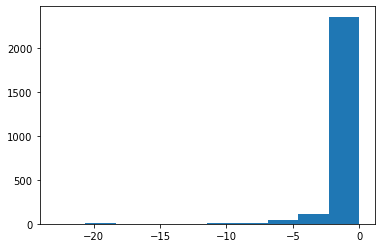

In [18]:
import matplotlib.pyplot as plt

plt.hist(train_cv['test_neg_mean_squared_error'])

In [23]:
train_cv['test_neg_mean_squared_error'].min()

-22.91710375590229

In [40]:
gas_list = ['total','CO2','CFCs','Methane','E&E']
input_feature = ['V','S','L','BET','Vt','Vmic','Vmeso','Temp(K)','Pressure']
output = ['Adsorp(mmol/g)']
train_df_com = train_df
#test_df_com = test_df
train_x = train_df_com[input_feature].values
#test_x = test_df_com[input_feature]
train_y = train_df_com[output].values
model = LGBMRegressor(n_estimators=300,learning_rate=0.1,num_leaves=20,n_jobs = -1,random_state = 42)
out_cv = LeavePGroupsOut(n_groups=1)
train_y_real = np.array([])
train_y_pred = np.array([])
train_y_label = np.array([])
labels = train_df_com['Label'].values

for train_index, test_index in out_cv.split(train_x, train_y, groups):

    
    X_train, X_test = train_x[train_index], train_x[test_index]
    y_train, y_test = train_y[train_index], train_y[test_index]
    test_label = labels[test_index]
            
    model.fit(X_train,y_train.squeeze())
    temp_pred = model.predict(X_test)
    train_y_real = np.append(train_y_real,y_test)
    train_y_pred = np.append(train_y_pred,temp_pred)
    train_y_label = np.append(train_y_label,test_label)
        
LOO_mse = mean_squared_error(train_y_real,train_y_pred)
LOO_r2  = r2_score(train_y_real,train_y_pred)
    #return LOO_r2,LOO_mse
print('Algorithm {}, Test_r2 {}, Test_error {}'.format(model_name,LOO_r2,LOO_mse))


Algorithm LGBM, Test_r2 0.9500334997948807, Test_error 0.6800173312818948


In [41]:
new_df =pd.DataFrame()
new_df['Y_real'] = train_y_real
new_df['Y_pred'] = train_y_pred
new_df['Label']  = train_y_label
for gas in gas_list[1:]:
    test_df_com = new_df[new_df['Label']==gas]
    test_xs = test_df_com['Y_real'].values
    test_ys = test_df_com['Y_pred'].values
    test_r2,test_mse = r2_score(test_xs,test_ys),mean_squared_error(test_xs,test_ys)
    #result_total.append([gas,model_name+'_total',result[0],result[1],test_r2_total,test_mse_total,test_r2,test_mse,best_param])

    print('Dataset {}, Algorithm {}, Test_r2 {}, Test_error {}'.format(gas,model_name+'_total',test_r2,test_mse))

            

Dataset CO2, Algorithm LGBM_total, Test_r2 0.9562962907428596, Test_error 0.6702448977920076
Dataset CFCs, Algorithm LGBM_total, Test_r2 0.9518096421443186, Test_error 0.5347854898176997
Dataset Methane, Algorithm LGBM_total, Test_r2 0.9300525388065435, Test_error 0.8476769299786685
Dataset E&E, Algorithm LGBM_total, Test_r2 0.9493564522255586, Test_error 0.3982302375792384
